In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import numpy as np
import pandas as pd
import pmdarima as pm

In [2]:
goog = yf.Ticker("GOOG")
p = goog.history(end='2021-01-01', start='2005-01-01')
p = p.resample('1D').mean()
p.fillna(method='ffill', inplace=True)

In [463]:
result = seasonal_decompose(p['Close'], period=365)

In [466]:
season = result.seasonal.to_frame().reset_index()
season['year'] = season.Date.dt.year
season['month'] = season.Date.dt.month
season['day'] = season.Date.dt.day

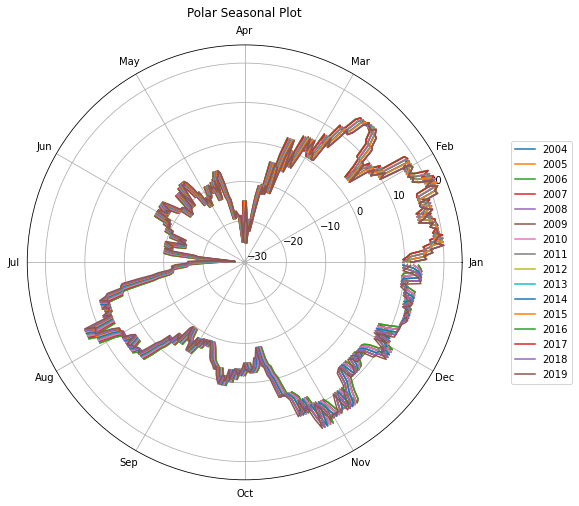

In [493]:
fig, ax = plt.subplots(figsize=(15, 8), 
                       subplot_kw={'projection': 'polar'})
for y in range(season.year.min()+1, season.year.max()+1):
    single_year = season[season.year == y]
    theta = np.arange(len(single_year)) / len(single_year)
    theta = (theta * 360 / 180) * np.pi
    ax.plot(theta, single_year['seasonal'])
    
ax.set_thetagrids(
    angles=range(0, 360, int(360/12)), 
    labels=[
        'Jan', 
        'Feb', 
        'Mar', 
        'Apr', 
        'May', 
        'Jun', 
        'Jul', 
        'Aug', 
        'Sep', 
        'Oct', 
        'Nov', 
        'Dec'
    ]
)

ax.legend([s for s in season.year.unique()], loc='center left', bbox_to_anchor=(1.1, 0.5))

ax.set_title("Polar Seasonal Plot", va='bottom')
plt.show()

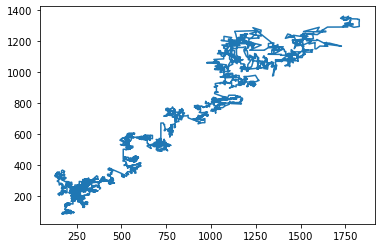

In [483]:
plt.plot(p['Close'], p['Close'].shift(365))

In [518]:
forecast = p['Close'].copy()
forecast = forecast[-730:]
forecast[-30:] = np.nan
forecast.fillna(method='ffill', inplace=True)

<AxesSubplot:xlabel='Date'>

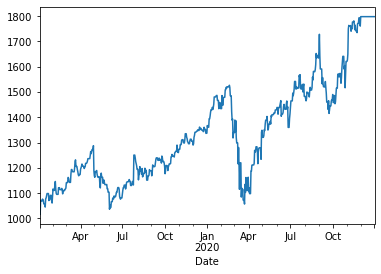

In [519]:
forecast.plot()

In [520]:
result = seasonal_decompose(forecast, period=365)

<AxesSubplot:xlabel='Date'>

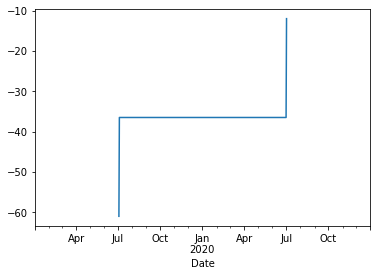

In [531]:
(result.resid + result.resid.mean())

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


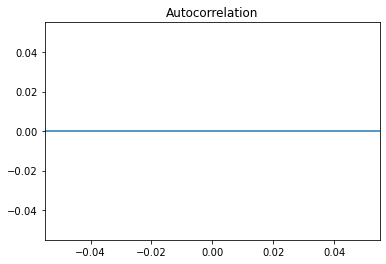

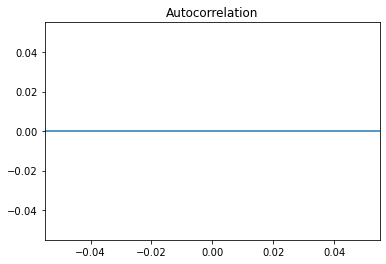

In [522]:
sm.graphics.tsa.plot_acf(result.resid, lags=30)

In [649]:
# One year forecast
# mean
mean_forecast = p['Close'].copy()
mean_forecast.iloc[-31:] = np.nan
mean_forecast.fillna(mean_forecast.mean(), inplace=True)
mean_forecast = mean_forecast[-31:]

# naive
naive_forecast = p['Close'].copy()
naive_forecast.iloc[-31:] = np.nan
naive_forecast.fillna(method='ffill', inplace=True)
naive_forecast = naive_forecast[-31:]

# naive
seasonal_naive_forecast = p['Close'].copy()
seasonal_naive_forecast = seasonal_naive_forecast[(seasonal_naive_forecast.index >= '2019-12-01') & (seasonal_naive_forecast.index <= '2019-12-31')]
seasonal_naive_forecast.index = p['Close'].index[-31:].copy()

# Drift
m = (p['Close'][:-31][-1] - p['Close'][:-31][0]) / len(p['Close'][:-31])
c = p['Close'][:-31][0]
drift = np.array(range(len(p), len(p) + 31)) * m + c
drift = pd.Series(drift)
drift.index = p['Close'].index[-31:].copy()


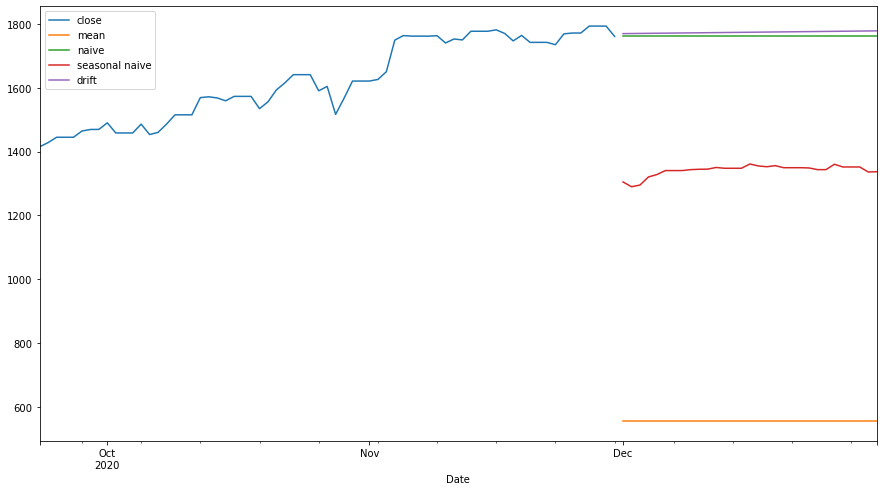

In [650]:
fig, ax = plt.subplots(figsize=(15, 8))

p['Close'][-100:-31].plot()
mean_forecast.plot()
naive_forecast.plot()
seasonal_naive_forecast.plot()
drift.plot()
plt.legend(['close', 'mean', 'naive', 'seasonal naive', 'drift'])
plt.show()

In [654]:
drift

Date
2020-12-01    1769.616126
2020-12-02    1769.902453
2020-12-03    1770.188780
2020-12-04    1770.475107
2020-12-05    1770.761434
2020-12-06    1771.047761
2020-12-07    1771.334088
2020-12-08    1771.620415
2020-12-09    1771.906742
2020-12-10    1772.193069
2020-12-11    1772.479396
2020-12-12    1772.765723
2020-12-13    1773.052050
2020-12-14    1773.338377
2020-12-15    1773.624704
2020-12-16    1773.911030
2020-12-17    1774.197357
2020-12-18    1774.483684
2020-12-19    1774.770011
2020-12-20    1775.056338
2020-12-21    1775.342665
2020-12-22    1775.628992
2020-12-23    1775.915319
2020-12-24    1776.201646
2020-12-25    1776.487973
2020-12-26    1776.774300
2020-12-27    1777.060627
2020-12-28    1777.346954
2020-12-29    1777.633281
2020-12-30    1777.919608
2020-12-31    1778.205935
Freq: D, dtype: float64

In [671]:
errors = []
y = p['Close'][-31:]
for f in [mean_forecast, naive_forecast, seasonal_naive_forecast, drift]:
    e = y - f
    # RMSE
    RMSE = sum((e ** 2 / len(f))) ** .5

    # MAE
    MAE = sum(abs(e) / len(f))

    # MAPE
    MAPE = e / y
    MAPE = np.mean(MAPE)
    MAPE *= 100

    # MASE
    seasonal_mae = sum(abs(y - seasonal_naive_forecast)) / (len(seasonal_naive_forecast) - 1)
    MASE = e / seasonal_mae
    MASE = np.mean(MASE)
    
    errors.append(pd.Series([RMSE, MAE, MAPE, MASE]))

In [672]:
errors = pd.concat(errors, axis=1).T
errors.index = ['mean', 'naive', 'seasonal naive', 'drift']
errors.columns = ['RMSE', 'MAE', 'MAPE', 'MASE']

In [673]:
errors

,RMSE,MAE,MAPE,MASE
mean,1216.288741,1215.785811,68.653556,2.742042
naive,36.333655,29.804837,0.517706,0.022210
seasonal naive,431.743271,429.084185,24.192447,0.967742
drift,37.261385,32.500827,-0.228793,-0.007496


In [683]:
# Ts cv
start = 1
length = 5
for i in range(start, len(p)):
    train = p['Close'][start:i + length]
    test = p['Close'][i + 1]
    break
    
print(train)
print(test)

Date
2005-01-01     96.035034
2005-01-02     96.035034
2005-01-03    100.976517
2005-01-04     96.886841
2005-01-05     96.393692
Freq: D, Name: Close, dtype: float64
96.0350341796875


In [687]:
result = seasonal_decompose(p['Close'][:-31], period=365)

In [688]:
result.resid * (1 + (1 / len(p) - 31)) ** .5

Date
2004-12-31   NaN
2005-01-01   NaN
2005-01-02   NaN
2005-01-03   NaN
2005-01-04   NaN
              ..
2020-11-26   NaN
2020-11-27   NaN
2020-11-28   NaN
2020-11-29   NaN
2020-11-30   NaN
Freq: D, Name: resid, Length: 5814, dtype: complex128

In [820]:
class X11:
    def __init__(self):
        pass
    
    def henderson_filter(self, series, filter_len):
        if filter_len not in [5, 7, 9, 13, 23]:
            raise Exception("Only filter length of 5, 7, 9, 13, 23 are available.")

        if filter_len == 5:
            weights = np.array([-0.073, 0.294, 0.558, 0.294, -0.073])

        elif filter_len == 7:
            weights = np.array([-0.059, 0.059, 0.294, 0.412, 0.294, 0.059, -0.059])

        elif filter_len == 9:
            weights = np.array([-0.041, -0.010, 0.119, 0.267, 0.330, 0.267, 0.119, -0.010, -0.041])

        elif filter_len == 13:
            weights = np.array([-0.019, -0.028, 0.0, 0.066, 0.147, 0.214, 0.240, 0.214, 0.147, 0.066, 0.0, -0.028, -0.019])    

        elif filter_len == 23:
            weights = np.array([-0.004, -0.011, -0.016, -0.015, -0.005, 0.013, 0.039, 0.068, 0.097, 0.122, 0.138, 0.148, 0.138, 0.122, 0.097, 0.068, 0.039, 0.013, -0.005, -0.015, -0.016, -0.011, -0.004])    

        sum_weights = np.sum(weights)

        return series.rolling(window=filter_len, center=True).apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)
    
    def fit(self,series, seasonal_freq):
        # 1) initial trend = centered moving averages for 13 observations
        trend_estimate = series.rolling(13, center=True).mean().rolling(2, center=True).mean()

        # 2) seasonal and irregular components (SI) = original series - initial estimate
        si = series - trend_estimate

        # 3) seasonal component = centered moving average of the SI series at seasonal frequencies (12 or 24)
        seasonal_component = si.rolling(seasonal_freq, center=True).mean().rolling(2, center=True).mean()

        # 4) seasonally adjusted series = original series - seasonal component
        seasonal_adjusted_series = series - seasonal_component

        # 5) Calculate another estimate of the trend using a different set of weights (known as "Henderson weights").
        trend_estimate_henderson = self.henderson_filter(seasonal_adjusted_series, 13).rolling(2, center=True).mean()

        # 6) Remove the trend again and calculate another estimate of the seasonal factor.
        si_henderson = series - trend_estimate_henderson
        seasonal_component_henderson = si_henderson.rolling(seasonal_freq, center=True).mean().rolling(2, center=True).mean()

        # 7) Seasonally adjust the series again with the new seasonal factors.
        seasonal_adjusted_series_henderson = series - seasonal_component_henderson

        # 8) Calculate the final trend and irregular components from the seasonally adjusted series.
        final_trend = self.henderson_filter(seasonal_adjusted_series_henderson, 13).rolling(2, center=True).mean()
        final_si = series - final_trend
        final_seasonal_component = final_si.rolling(seasonal_freq, center=True).mean().rolling(2, center=True).mean()
        final_irreuglar_components = series - final_trend - final_seasonal_component
        
        # Store attributes
        self.final_trend = final_trend
        self.final_si = final_si
        self.final_seasonal_component = final_seasonal_component
        self.final_irreuglar_components = final_irreuglar_components
        
        # Forward Fit your model
        forward_model = pm.auto_arima(x13.final_trend.dropna(), seasonal=True, m=12)

        # make your forecasts
        forward_forecasts = forward_model.predict(28)  # predict N steps into the future

        self.final_trend.iloc[-28:] = forward_forecasts

        # Backward Fit your model
        backward_model = pm.auto_arima(x13.final_trend.iloc[::-1].dropna(), seasonal=True, m=12)

        # make your forecasts
        backward_forecasts = backward_model.predict(35)  # predict N steps into the future

        self.final_trend.iloc[:35] = backward_forecasts

        
x11 = X11()        
x11.fit(p['Close'][:255], seasonal_freq=12)



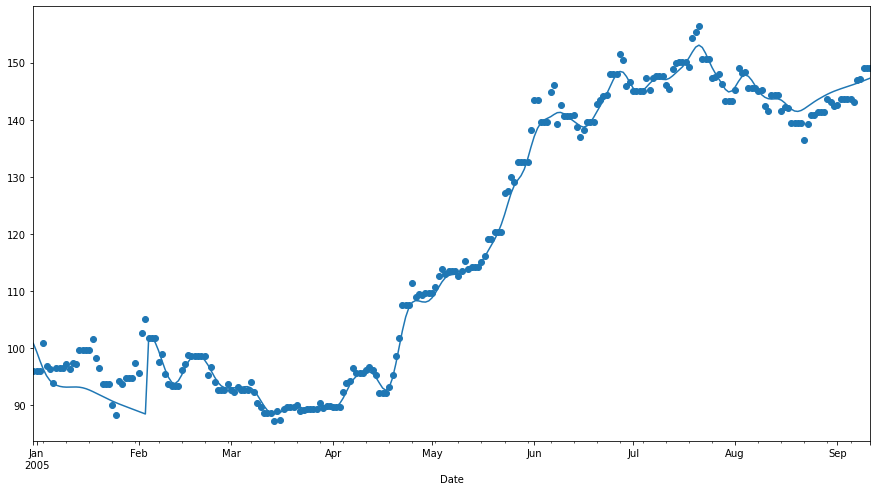

In [818]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(p['Close'][:255].index, p['Close'][:255])
# x13.trend_estimate.plot()
# x13.init_seasonal_adjusted_series.plot()
# x13.trend_estimate_henderson.plot()
# x13.init_seasonal_adjusted_series_henderson.plot()
x13.final_trend.plot()

#plt.legend(['Initial Seasonal Adjusted Series', 'Initial Trend Estimate', 'Close Price'])
plt.show()

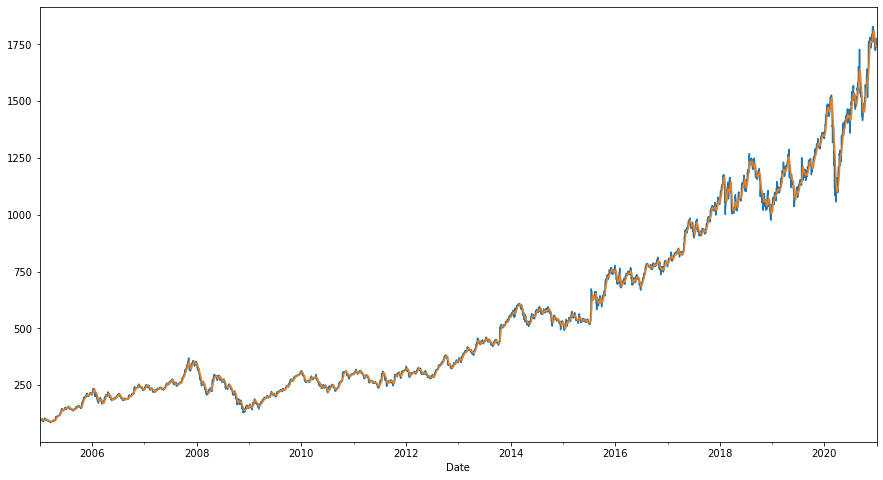

In [705]:
fig, ax = plt.subplots(figsize=(15, 8))
p['Close'].plot()
# An initial estimate of the trend is obtained by 
# calculating centered moving averages for 13 
# observations (from t - 6 to t + 6)
p['Close'].rolling(6).mean().rolling(2).mean().plot()
plt.show()

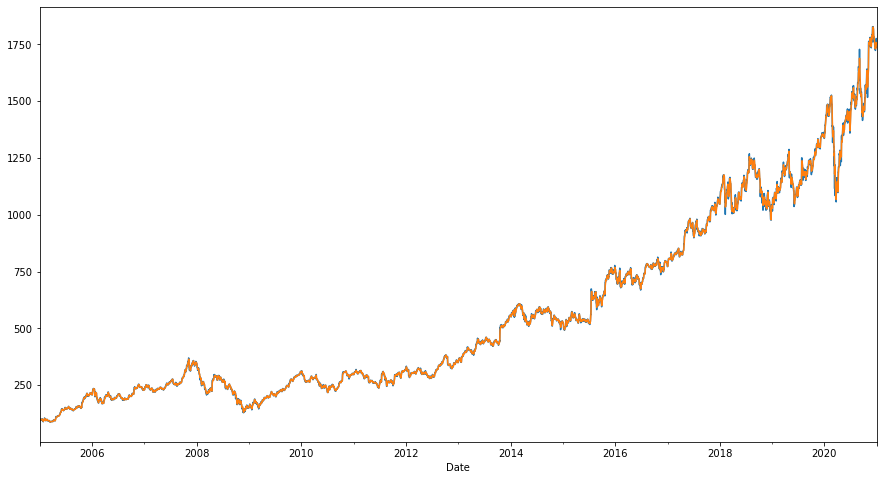

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
p['Close'].plot()
p['Close'].ewm(alpha=.5).mean().plot()
plt.show()

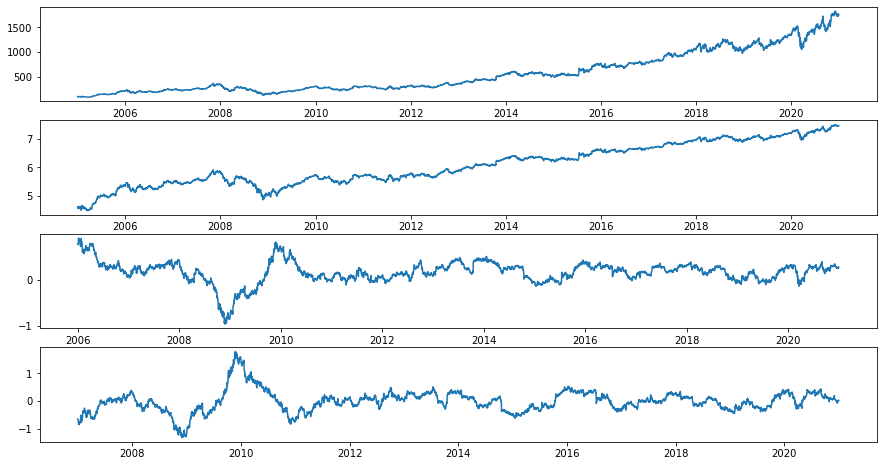

In [31]:
fig, ax = plt.subplots(4,1, figsize=(15, 8))
ax = ax.flatten()
ax[0].plot(p['Close'])
ax[1].plot(np.log(p['Close']))
ax[2].plot(np.log(p['Close']).diff(365))
ax[3].plot(np.log(p['Close']).diff(365).diff(365))
plt.show()

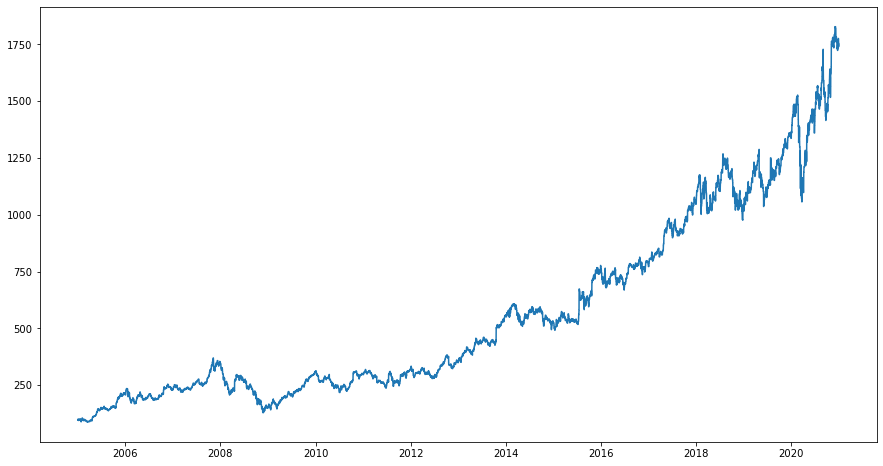

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(p['Close'].asfreq('H').fillna(method='ffill'))